AI/ML project for a graduate level course in optimization for industrial systems

Tested on the NASA open-source dataset found in  https://data.nasa.gov/dataset/ims-bearings

Start with loading in one chunk of the data, to plot preview

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



df = pd.read_csv("../data/IMS/1st_test/2003.11.23.20.11.24", sep="\t")

df0 = pd.read_csv("../data/IMS/1st_test/2003.11.23.20.21.24", sep="\t", )

df.columns = ["B1_X", "B1_Y","B2_X", "B2_Y","B3_X", "B3_Y","B4_X", "B4_Y" ]
df0.columns = ["B1_X", "B1_Y","B2_X", "B2_Y","B3_X", "B3_Y","B4_X", "B4_Y" ]

df.head()




,B1_X,B1_Y,B2_X,B2_Y,B3_X,B3_Y,B4_X,B4_Y
0,-0.176,0.044,-0.107,-0.039,-0.198,-0.051,-0.039,-0.186
1,-0.237,-0.007,-0.264,-0.137,-0.083,-0.239,-0.051,-0.186
2,-0.151,-0.110,-0.256,-0.195,-0.146,-0.149,-0.310,-0.042
3,-0.200,-0.168,-0.066,-0.195,-0.300,-0.198,-0.300,0.085
4,-0.330,-0.034,-0.212,-0.220,-0.171,-0.020,-0.134,-0.149


[   0    1    2 ... 3997 3998 3999]


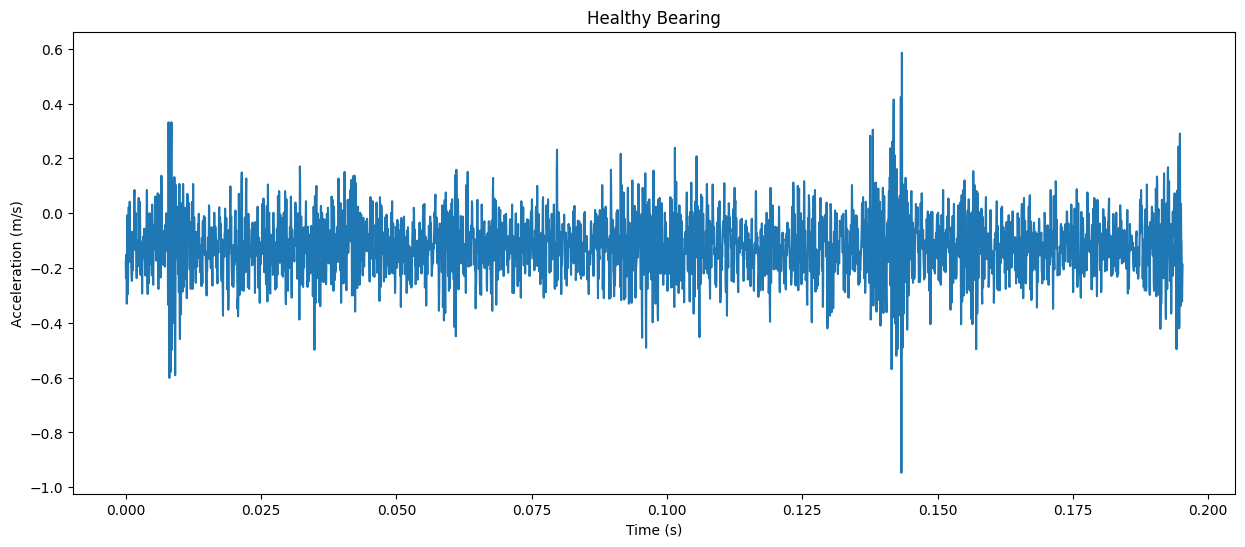

[   0    1    2 ... 3998 3999 4000]


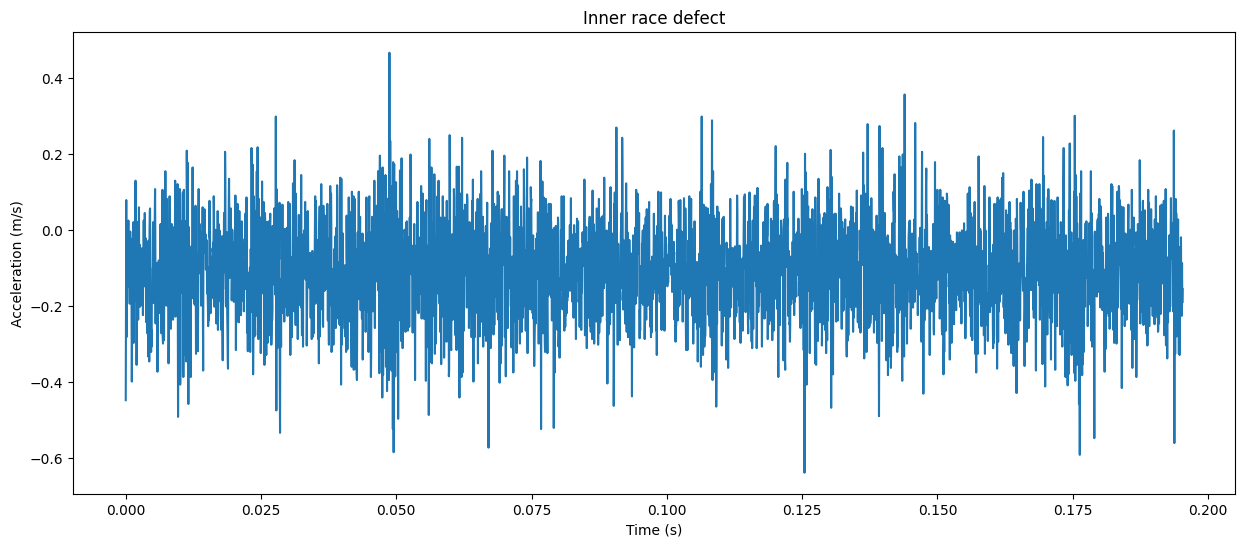

[   0    1    2 ... 3998 3999 4000]


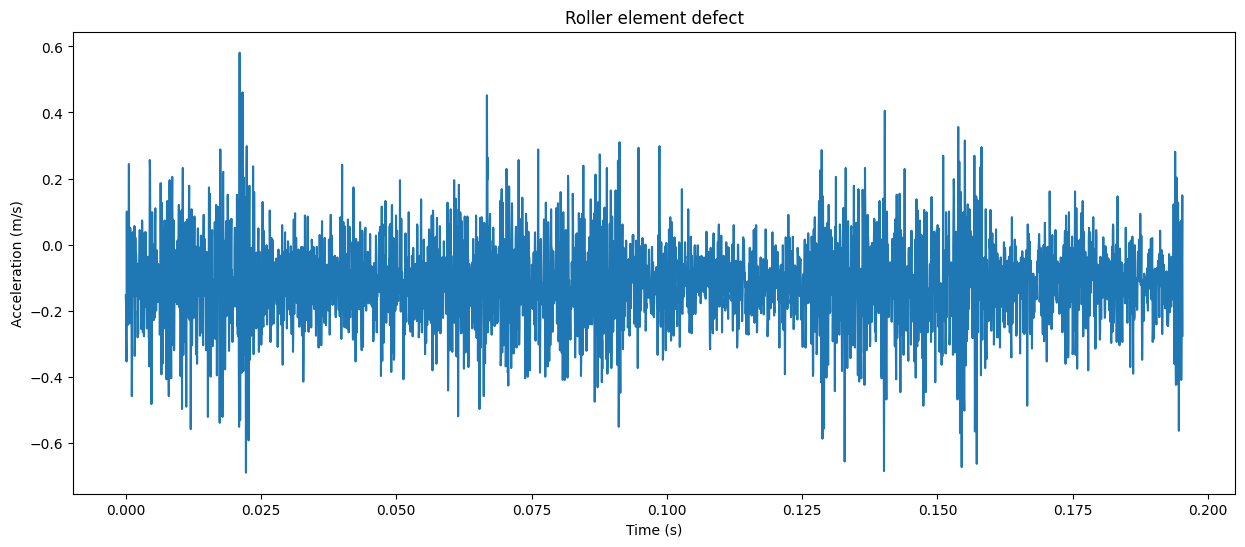

In [ ]:


ms100_df = df.head(4000) 

Fs = 20480
samples = np.arange(0, len(ms100_df))
print(samples)

time = samples/Fs

plt.figure(figsize=(15, 6))
plt.plot(time, ms100_df['B1_X'])

plt.title("Healthy Bearing")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s)")

plt.show()

# Plot time? This data is sampled over 1 second, let's have a look over 0.1s as well
# Add labels, 1 second snapshot 
# Also show both defects.

ms100_df = df.loc[len(df) // 1.3 : len(df) // 1.3 + 4000 - 1]


samples = np.arange(0, len(ms100_df))
print(samples)

time = samples/Fs



plt.figure(figsize=(15, 6))
plt.plot(time, ms100_df['B3_X'])

plt.title("Inner race defect")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s)")

plt.show()

samples = np.arange(0, len(ms100_df))
print(samples)

time = samples/Fs

plt.figure(figsize=(15, 6))
plt.plot(time, ms100_df['B4_X'])

plt.title("Roller element defect")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s)")

plt.show()

[   0    1    2 ... 1859 1860 1861]


Compare the intersection between two chunks

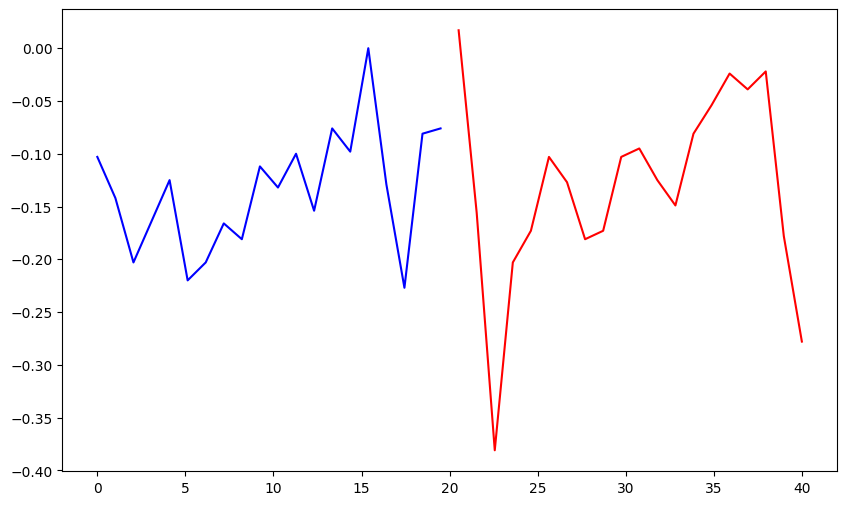

In [3]:
df1_last_10 = df.tail(20)  # Last 10 rows of df1
df2_first_10 = df0.head(20)  # First 10 rows of df2

plt.figure(figsize=(10, 6))

index = np.linspace(0, 40, 40)

# Plot the last 10 points from df1
plt.plot(index[0:20], df1_last_10['B1_X'], color='b')

# Plot the first 10 points from df2
plt.plot(index[20:40],df2_first_10['B1_X'], color='r')

plt.show()

Merge all chunks into one for plotting

In [4]:
import os

path = "../data/IMS/1st_test/"
data_filename = "1st_test_data"
data_file = os.path.join(path,data_filename)

if not os.path.isfile(data_file):

    filenames = []

    for (root, _, files) in os.walk(path):
        for file in files:
            filenames.append(os.path.join(root,file)) 

    filenames.sort()

    with open(data_file, 'wb') as outfile:
        for fname in filenames:
            with open(fname, 'rb') as infile:
                    outfile.write(infile.read())


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20479 entries, 0 to 20478
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   B1_X    20479 non-null  float64
 1   B1_Y    20479 non-null  float64
 2   B2_X    20479 non-null  float64
 3   B2_Y    20479 non-null  float64
 4   B3_X    20479 non-null  float64
 5   B3_Y    20479 non-null  float64
 6   B4_X    20479 non-null  float64
 7   B4_Y    20479 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


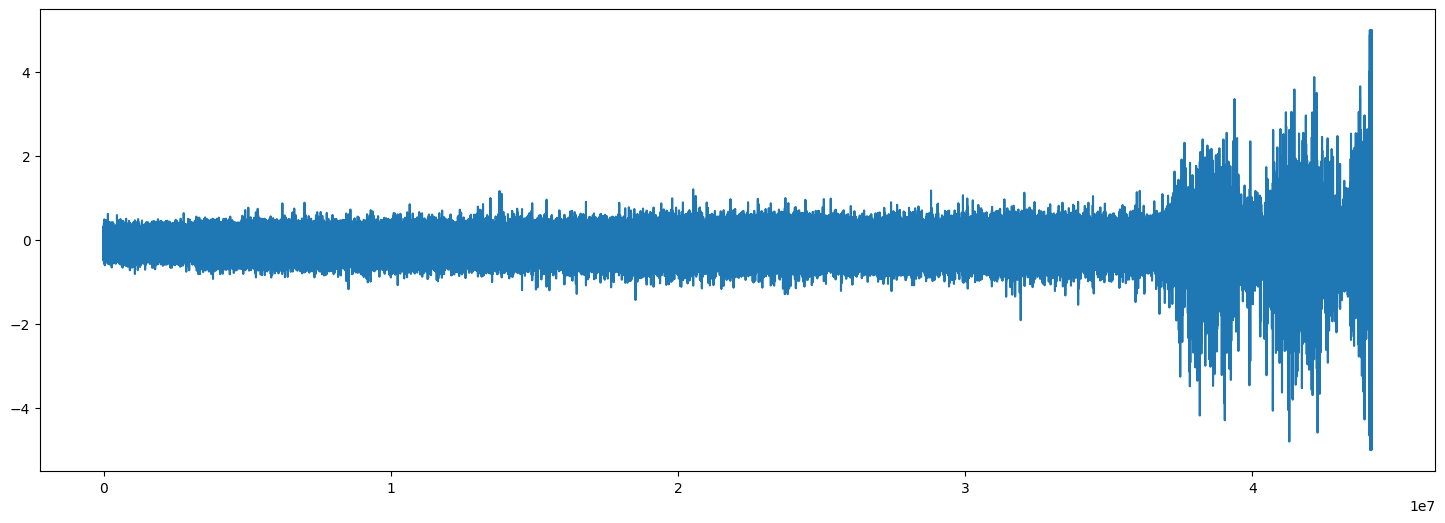

In [6]:
df = pd.read_csv("../data/IMS/1st_test/1st_test_data", sep="\t" ,usecols=[4], dtype= {4 : "float32"})

df.columns = ["X"]
df["X"].plot(figsize=(18,6))
plt.show()

Preprocessing steps:

Select which bearing to analyze 1,2,3 or 4

Then for each chunk caclulate the following features and add it to a new .csv

The mean signal amplitude for each chunk
The mean value of the FFT
The max value of the  FFT
The spectral centroid
The dominant frequency
The spectral entropy

Before calculating the features the magnitutde of the time-domain signal is calculated and then passed through two filters, a gaussian averaging and a low pass filter to remove high frequency noise. 

In [7]:
from scipy.fft import fft, fftfreq
from scipy.signal import welch
from scipy.stats import entropy
from scipy.signal import butter, filtfilt
from scipy.ndimage import gaussian_filter1d

b = 3 

bearings = {
        "bearing_1": [0, 1],
        "bearing_2": [2, 3],
        "bearing_3": [4, 5],
        "bearing_4": [6, 7]
    }

bearing = bearings[f"bearing_{b}"]

def butter_lowpass(cutoff, fs, order=4):
    nyquist = 0.5 * fs 
    normal_cutoff = cutoff / nyquist  
    b, a = butter(order, normal_cutoff, btype='low', analog=False) 
    return b, a


def butter_lowpass_filter(data, cutoff, fs, order=4):
    b, a = butter_lowpass(cutoff, fs, order)
    return filtfilt(b, a, data) 



N_tot = len(df)
N = 20000    # Chunk size
fs = 20e3
T = 1 / fs # Sampling frequency

""" Magnitude """

features = ["t_mean", "fft_mean", "fft_max", "fft_spec_centroid", "fft_dominant_frequency", "fft_entropy"]


path = "../data/IMS/1st_test/"
feature_file = os.path.join(path, f"features_{b}.csv")




if not os.path.isfile(feature_file):



    filenames = []

    for (root, _, files) in os.walk(path):
        for file in files:
            if file.startswith('200'):
                filenames.append(os.path.join(root,file)) 


    filenames.sort()
    i = 0
    
    for file in filenames:

        print(f"parsing file: {i}, out of {len(filenames)}")
        i = i + 1


        df = pd.read_csv(file, sep="\t",usecols=bearing, dtype= {bearing[0] : "float32", bearing[1] : "float32" })

        cutoff = 5000

        
        N = len(df)

        df.columns = ["X", "Y"]
        df["Mag"] = np.sqrt(df["X"]**2 + df["Y"]**2)

        
        
        df["gauss"] = gaussian_filter1d(df["Mag"], sigma=5)

        df["filtered"] = butter_lowpass_filter(df["gauss"], cutoff, fs)

        yf = fft(df["filtered"])
        # xf = fftfreq(N, T)[:N//2]
        f, Pxx = welch(df["filtered"].values, fs=fs, nperseg=512)

        feature = [np.mean(df["filtered"]), 
                    np.mean(np.abs(yf)[5:]),
                    np.max(np.abs(yf)[5:]), 
                    np.sum(f * Pxx) / np.sum(Pxx),
                    f[np.argmax(Pxx)],
                    entropy(Pxx / np.sum(Pxx))
                  ]

        df_features = pd.DataFrame([feature], columns=features)

        df_features.to_csv(feature_file, mode="a", header=False, index=False)
    
        

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44154879 entries, 0 to 44154878
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   X       float32
dtypes: float32(1)
memory usage: 168.4 MB


In [9]:
df = pd.read_csv(f"../data/IMS/1st_test/features_{b}.csv")
df.columns = ["t_mean", "fft_mean", "fft_max", "fft_spec_centroid", "fft_dominant_frequency", "fft_entropy"]
df = df.iloc[175:]

df.head()


,t_mean,fft_mean,fft_max,fft_spec_centroid,fft_dominant_frequency,fft_entropy
175,0.205588,1.155591,79.269282,366.821261,39.0625,3.121190
176,0.204897,1.188883,77.476816,368.534091,507.8125,3.097830
177,0.205629,1.184308,94.206953,366.803424,507.8125,3.101894
178,0.204367,1.185945,89.209579,366.598295,507.8125,3.102509
179,0.206935,1.193952,100.118174,351.389686,39.0625,3.072890


Scaled signals using normalization

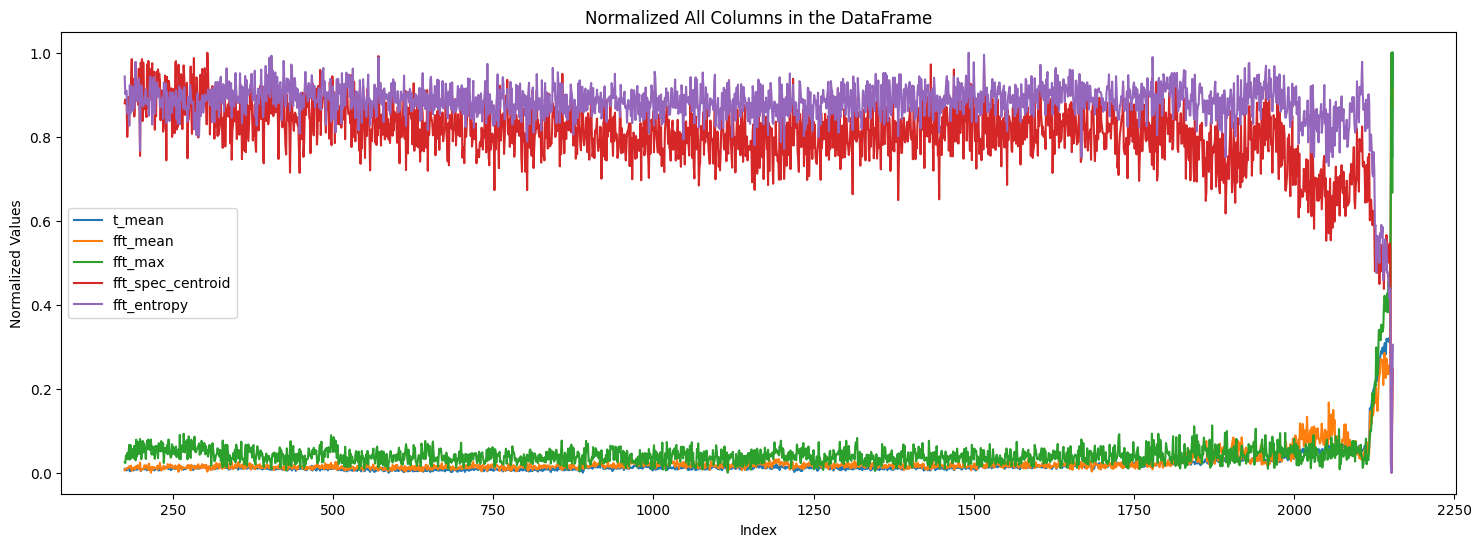

In [10]:

df_normalized = (df - df.min()) / (df.max() - df.min())
df_normalized = df_normalized.drop(columns=["fft_dominant_frequency"])


normalized_file = os.path.join(path, f"features_normalized_{b}.csv")
df_normalized.to_csv(normalized_file, mode="a", index=False)


df_normalized.plot(figsize=(18,6))

plt.xlabel('Index')
plt.ylabel('Normalized Values')
plt.title('Normalized All Columns in the DataFrame')

plt.show()


Plot the time-domain signal and the dominant frequency. 

<Axes: >

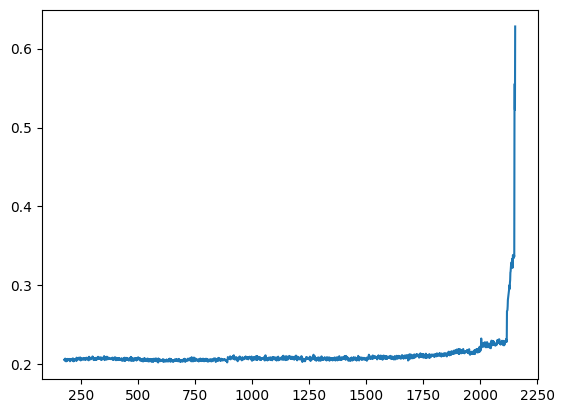

In [11]:

df["t_mean"].plot()


<Axes: >

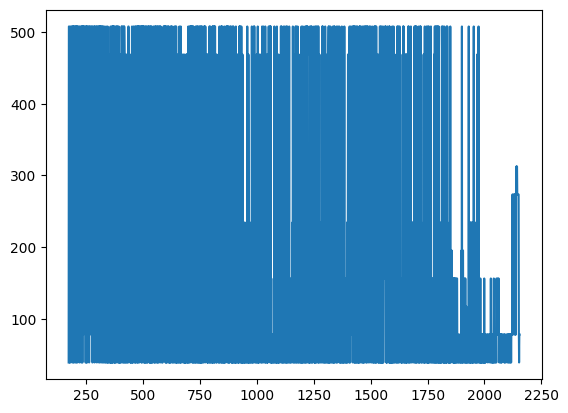

In [12]:
df["fft_dominant_frequency"].plot()

Scaled using standard scaler

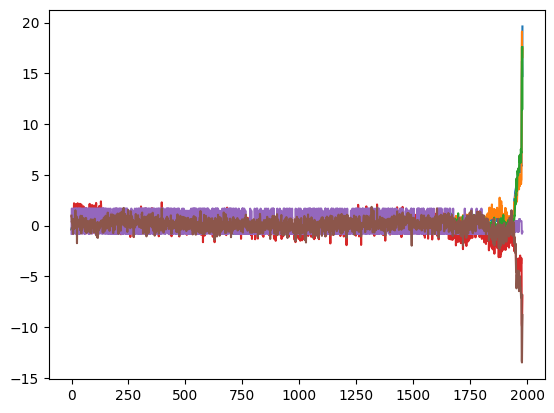

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

plt.plot(X_scaled)
plt.show()

scaled_file = os.path.join(path, f"features_scaled_{b}.csv")


scaled_df = pd.DataFrame(X_scaled, columns=df.columns)
scaled_df.to_csv(scaled_file, index=False)
